In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [201]:
df = pd.read_csv('MNCAATourneyCompactResults.csv')
df.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [202]:
#merge seeds and box score with compact results 
Seeds = pd.read_csv('MNCAATourneySeeds.csv')
BoxScore = pd.read_csv('MNCAATourneyDetailedResults.csv')
df = df.merge(Seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'WSeed'})
df = df.merge(Seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'LSeed'})

df = df.merge(BoxScore, how='left', left_on=['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT'], right_on=['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT'])

#seed to float
df['WSeed'] = df['WSeed'].str.replace(r'[^0-9]', '').astype('float')
df['LSeed'] = df['LSeed'].str.replace(r'[^0-9]', '').astype('float')

#add point differential 
NewCol = df["WScore"] - df["LScore"]
df.insert(0, 'PointDiff', NewCol)


df.tail()

,PointDiff,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2246,6,2019,146,1120,77,1246,71,N,1,5.0,...,21.0,12.0,21.0,11.0,30.0,14.0,14.0,5.0,5.0,19.0
2247,1,2019,146,1277,68,1181,67,N,0,2.0,...,21.0,8.0,13.0,13.0,29.0,14.0,17.0,4.0,9.0,9.0
2248,10,2019,152,1403,61,1277,51,N,0,3.0,...,24.0,14.0,18.0,8.0,28.0,6.0,11.0,1.0,2.0,15.0
2249,1,2019,152,1438,63,1120,62,N,0,1.0,...,31.0,11.0,14.0,9.0,24.0,9.0,5.0,3.0,3.0,12.0
2250,8,2019,154,1438,85,1403,77,N,1,1.0,...,30.0,13.0,15.0,9.0,23.0,9.0,8.0,6.0,3.0,18.0


In [203]:
df["PointDiff"] = df["PointDiff"].astype(float)

In [204]:
#add seed differential 
NewCol1 = df["WSeed"] - df["LSeed"]
df.insert(loc=0, column='SeedDiff', value=NewCol1)

df.tail()

,SeedDiff,PointDiff,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2246,3.0,6.0,2019,146,1120,77,1246,71,N,1,...,21.0,12.0,21.0,11.0,30.0,14.0,14.0,5.0,5.0,19.0
2247,1.0,1.0,2019,146,1277,68,1181,67,N,0,...,21.0,8.0,13.0,13.0,29.0,14.0,17.0,4.0,9.0,9.0
2248,1.0,10.0,2019,152,1403,61,1277,51,N,0,...,24.0,14.0,18.0,8.0,28.0,6.0,11.0,1.0,2.0,15.0
2249,-4.0,1.0,2019,152,1438,63,1120,62,N,0,...,31.0,11.0,14.0,9.0,24.0,9.0,5.0,3.0,3.0,12.0
2250,-2.0,8.0,2019,154,1438,85,1403,77,N,1,...,30.0,13.0,15.0,9.0,23.0,9.0,8.0,6.0,3.0,18.0


In [205]:
#Points
df['WPts'] = df.apply(lambda x: 2*x.WFGM + x.WFGM3 + x.WFTM, axis=1)
df['LPts'] = df.apply(lambda x: 2*x.LFGM + x.LFGM3 + x.LFTM, axis=1)

#Possessions for each team
#This is the generally accepted best method for calculating possessions
wPos = df.apply(lambda x: 0.96*(x.WFGA + x.WTO + 0.44*x.WFTA - x.WOR), axis=1)
lPos = df.apply(lambda x: 0.96*(x.LFGA + x.LTO + 0.44*x.LFTA - x.LOR), axis=1)

#average possessions for good estimate
df['Pos'] = (wPos+lPos)/2

#Offensive efficiency = 100 x (Points / Possessions)
df['WOffRtg'] = df.apply(lambda x: 100 * (x.WPts / x.Pos), axis=1)
df['LOffRtg'] = df.apply(lambda x: 100 * (x.LPts / x.Pos), axis=1)
#Defensive efficiency = 100 x (Opponent points / Opponent possessions)
df['WDefRtg'] = df.LOffRtg
df['LDefRtg'] = df.WOffRtg
#Net Rating = Off.Rtg - Def.Rtg
df['WNetRtg'] = df.apply(lambda x:(x.WOffRtg - x.WDefRtg), axis=1)
df['LNetRtg'] = df.apply(lambda x:(x.LOffRtg - x.LDefRtg), axis=1)

#Field Goal Percantage
df['WFG%'] = df.apply(lambda x: (x.WFGM / x.WFGA), axis=1)
df['LFG%'] = df.apply(lambda x: (x.LFGM / x.LFGA), axis=1)

#True Shooting Percentage = Points/2(Field Goal Attempts + .44(Free Throw Attempts))
df['WTS%'] = df.apply(lambda x: 100*((x.WFGM3 + 2*x.WFGM + x.WFTM) / (2*(x.WFGA + .44*x.WFTA))), axis=1)
df['LTS%'] = df.apply(lambda x: 100*((x.LFGM3 + 2*x.LFGM + x.WFTM) / (2*(x.LFGA + .44*x.LFTA))), axis=1)

df.tail()


,SeedDiff,PointDiff,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,...,WOffRtg,LOffRtg,WDefRtg,LDefRtg,WNetRtg,LNetRtg,WFG%,LFG%,WTS%,LTS%
2246,3.0,6.0,2019,146,1120,77,1246,71,N,1,...,110.025149,101.451760,101.451760,110.025149,8.573388,-8.573388,0.400000,0.442623,50.952885,54.812073
2247,1.0,1.0,2019,146,1277,68,1181,67,N,0,...,104.659180,103.120075,103.120075,104.659180,1.539106,-1.539106,0.428571,0.456140,46.806167,48.628827
2248,1.0,10.0,2019,152,1403,61,1277,51,N,0,...,107.116768,89.556642,89.556642,107.116768,17.560126,-17.560126,0.431373,0.319149,53.772920,40.968682
2249,-4.0,1.0,2019,152,1438,63,1120,62,N,0,...,112.718997,110.929806,110.929806,112.718997,1.789190,-1.789190,0.490196,0.381818,55.970149,46.599084
2250,-2.0,8.0,2019,154,1438,85,1403,77,N,1,...,128.582147,116.480298,116.480298,128.582147,12.101849,-12.101849,0.457627,0.428571,61.487269,60.344828


In [206]:
print(df.columns.values)
print(df.dtypes)

['SeedDiff' 'PointDiff' 'Season' 'DayNum' 'WTeamID' 'WScore' 'LTeamID'
 'LScore' 'WLoc' 'NumOT' 'WSeed' 'LSeed' 'WFGM' 'WFGA' 'WFGM3' 'WFGA3'
 'WFTM' 'WFTA' 'WOR' 'WDR' 'WAst' 'WTO' 'WStl' 'WBlk' 'WPF' 'LFGM' 'LFGA'
 'LFGM3' 'LFGA3' 'LFTM' 'LFTA' 'LOR' 'LDR' 'LAst' 'LTO' 'LStl' 'LBlk'
 'LPF' 'WPts' 'LPts' 'Pos' 'WOffRtg' 'LOffRtg' 'WDefRtg' 'LDefRtg'
 'WNetRtg' 'LNetRtg' 'WFG%' 'LFG%' 'WTS%' 'LTS%']
SeedDiff     float64
PointDiff    float64
Season         int64
DayNum         int64
WTeamID        int64
WScore         int64
LTeamID        int64
LScore         int64
WLoc          object
NumOT          int64
WSeed        float64
LSeed        float64
WFGM         float64
WFGA         float64
WFGM3        float64
WFGA3        float64
WFTM         float64
WFTA         float64
WOR          float64
WDR          float64
WAst         float64
WTO          float64
WStl         float64
WBlk         float64
WPF          float64
LFGM         float64
LFGA         float64
LFGM3        float64
LFGA3    

In [ ]:
#Below, I created a correlation matric for all of the variables. 
# I had trouble isolating only the PointDiff row, but that's really the only row I care about. 
#Takeaways: OffRtg, DefRtg, NetRtg, FG%, TS%, SeedDiff, WScore, WDR, and WAst all have strongest correlation with PointDif
#note that although NetRtg has a correlation of .99/-.99, that's expected since it measures points scored/ points allowed 
#per posessions. Obviously that would indicate success, the challenge is predicting who will have the higher net rating

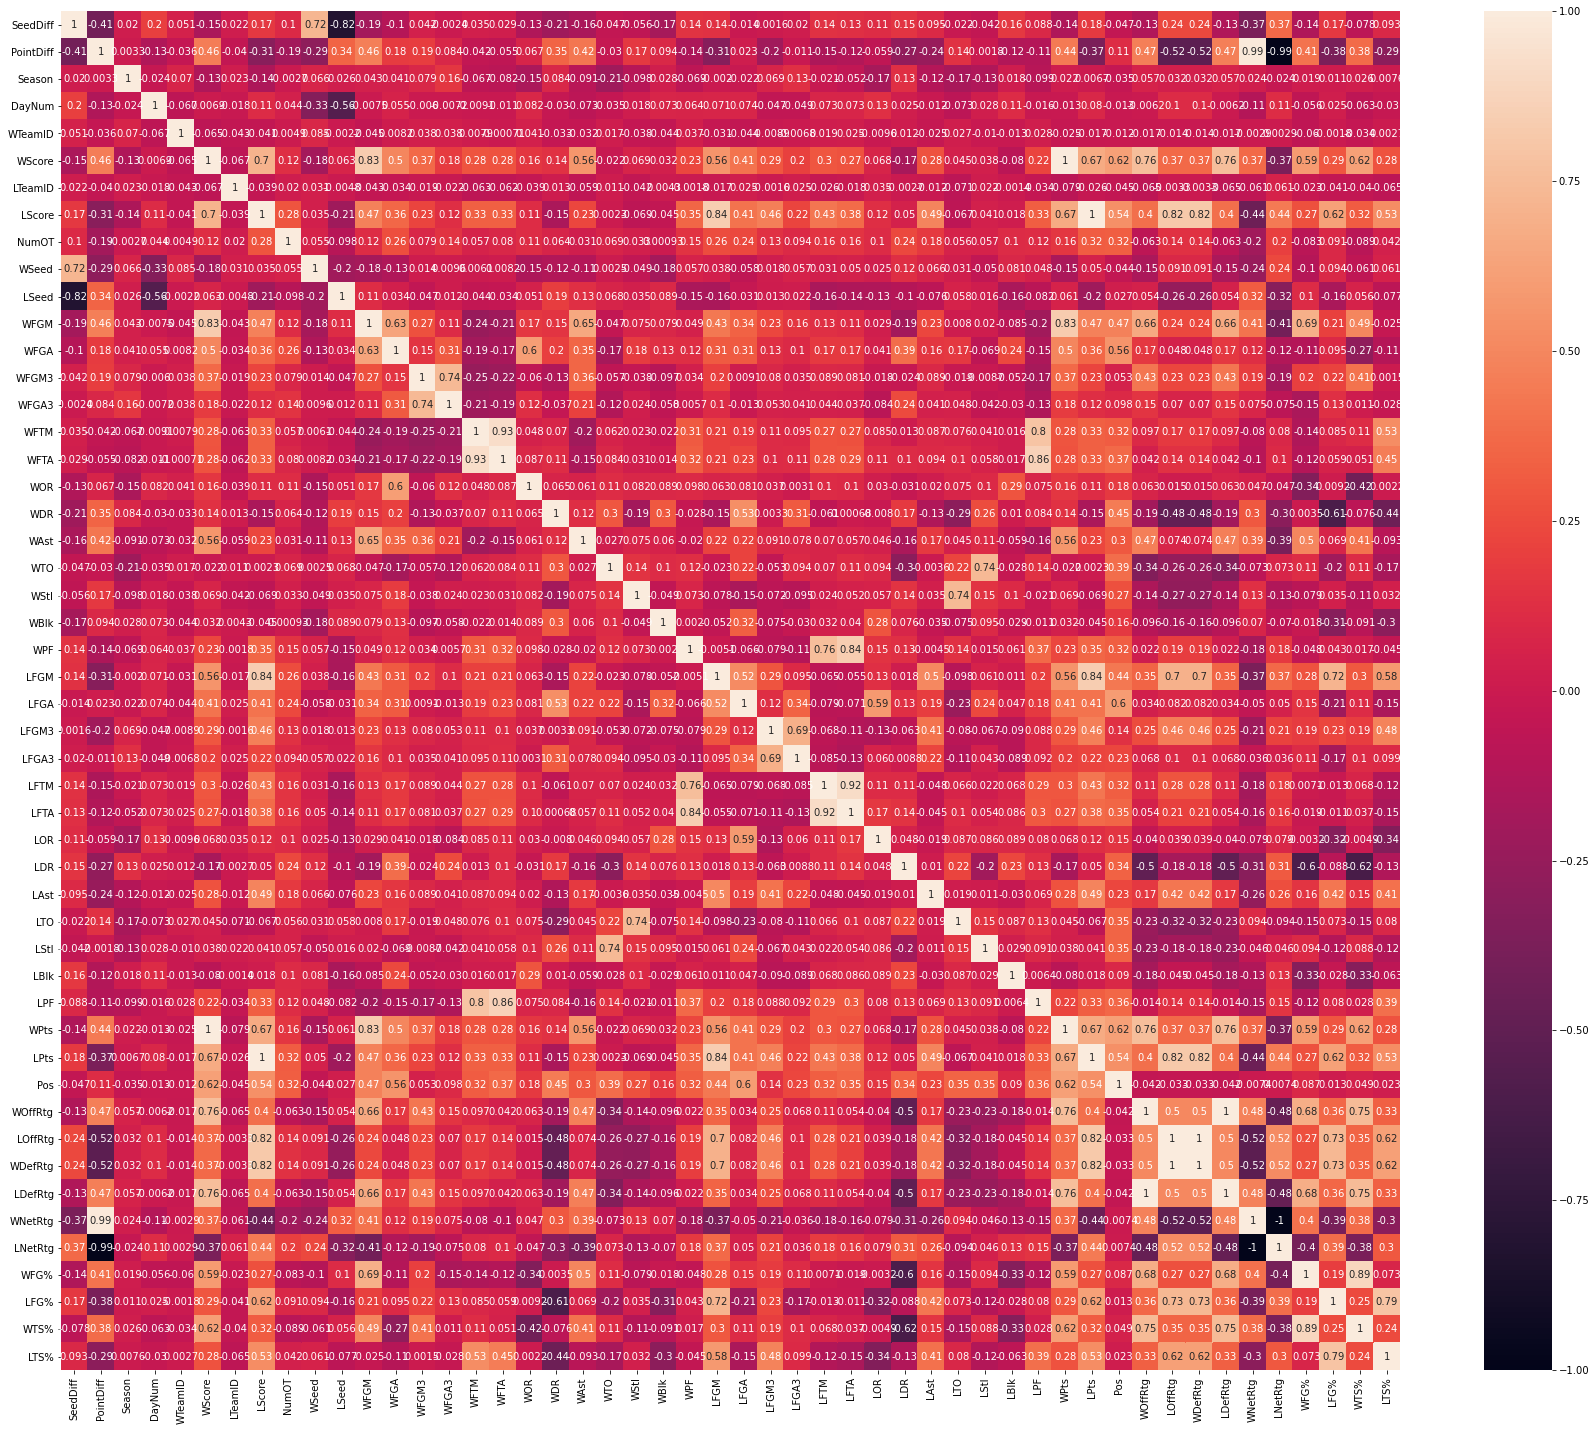

In [207]:
corrMatrix = df[df.columns[:]].corr()
fig, ax = plt.subplots(figsize=(30,25))
sns.heatmap(corrMatrix, annot=True)
plt.show()

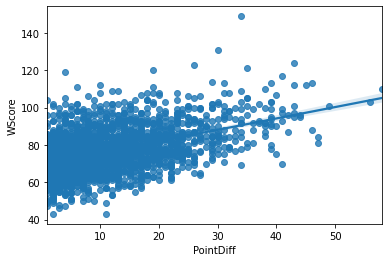

In [208]:
sns.regplot(x = "PointDiff", y = "WScore", data = df)

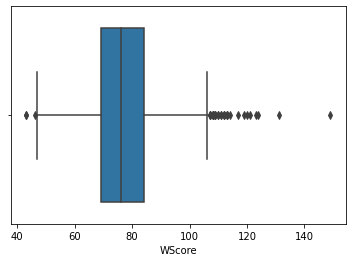

In [209]:
sns.boxplot(x = "WScore", data = df)